In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
# 이미지 데이터셋 다운로드
import urllib.request
import zipfile

# 데이터셋을 다운로드 합니다.
# 다운로드 후 tmp 폴더에 압축을 해제 합니다.
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
urllib.request.urlretrieve(url, 'cats_and_dogs.zip')
local_zip = 'cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

하단의 code snippets는 corrupted 된(깨진) 이미지를 확인하고 제거하기 위한 코드 입니다. Cats vs Dogs데이터셋에도 원인 모를 이유 때문에 이미지 데이터가 corrupt된 파일이 2개가 존재합니다. 이렇게 corrupt 된 이미지를 DataLoader로 로드시 에러가 발생하기 때문에 전처리 때 미리 제거하도록 하겠습니다.

In [3]:
import os
from PIL import Image, UnidentifiedImageError

root = 'tmp/PetImages' # image 데이터셋 root 폴더

dirs = os.listdir(root)

for dir_ in dirs:
    folder_path = os.path.join(root, dir_)
    files = os.listdir(folder_path)

    images = [os.path.join(folder_path, f) for f in files if f.endswith(('jpg', 'png'))]
    for img in images:
        try:
            # PIL.Image로 이미지 데이터를 로드하려고 시도합니다.
            Image.open(img)
        except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력합니다.
            print(f'unidentified error..{img}')
            # corrupted 된 이미지 제거
            os.remove(img)

unidentified error..tmp/PetImages/Cat/666.jpg
unidentified error..tmp/PetImages/Dog/11702.jpg


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# 이미지 폴더로부터 데이터를 로드합니다.
dataset = ImageFolder(root='tmp/PetImages',                   # 다운로드 받은 폴더의 root 경로를 지정합니다.
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
                          transforms.ToTensor(),
                      ]))

data_loader = DataLoader(dataset,
                         batch_size=32,
                         shuffle=True,
                         num_workers=8
                        )

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# ImageFolder로부터 로드한 dataset의 클래스를 확인합니다.
# 총 2개의 클래스로 구성되었음을 확인할 수 있습니다(cats, dogs)
dataset.classes

['Cat', 'Dog']

In [6]:
# 1개의 배치를 추출합니다.
images, labels = next(iter(data_loader))

In [7]:
# 이미지의 shape을 확인합니다. 224 X 224 RGB 이미지 임을 확인합니다.
images[0].shape

torch.Size([3, 224, 224])

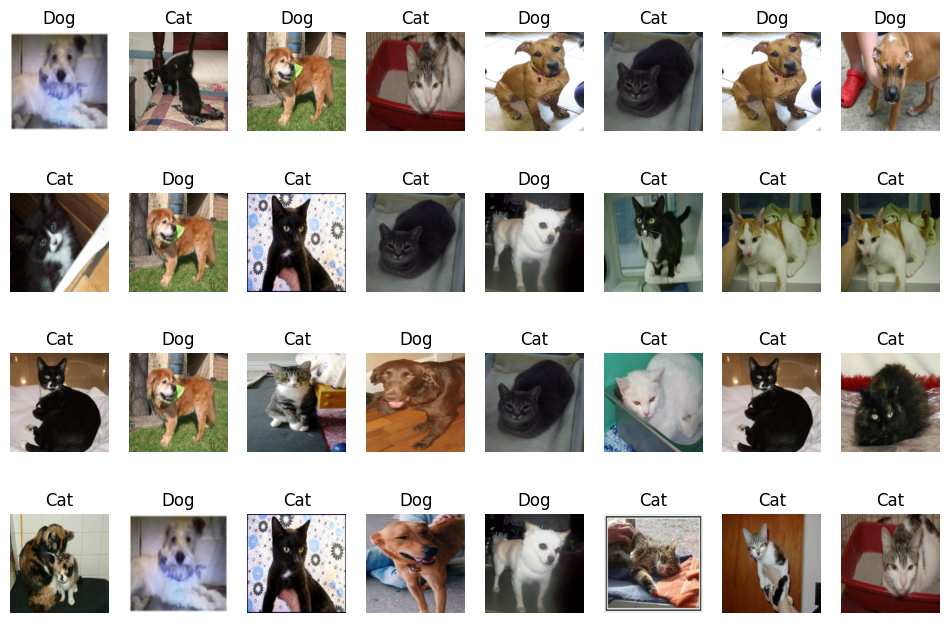

In [8]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [9]:
# Image Transform을 지정합니다.
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # (224, 224) 이미지 크기 조정
    transforms.RandomHorizontalFlip(0.5),        # 50% 확률로 Horizontal Flip
    transforms.ToTensor(),                       # Tensor 변환
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [10]:
# 이미지 폴더로부터 데이터를 로드합니다.
dataset = ImageFolder(root='tmp/PetImages/',            # 다운로드 받은 폴더의 root 경로를 지정합니다.
                      transform=image_transform) # Image Augmentation 적용

In [11]:
# Image Augmentation 이 적용된 DataLoader를 로드 합니다.
data_loader = DataLoader(dataset,
                         batch_size=32,
                         shuffle=True,
                         num_workers=8
                        )

# 1개의 배치를 추출합니다.
images, labels = next(iter(data_loader))

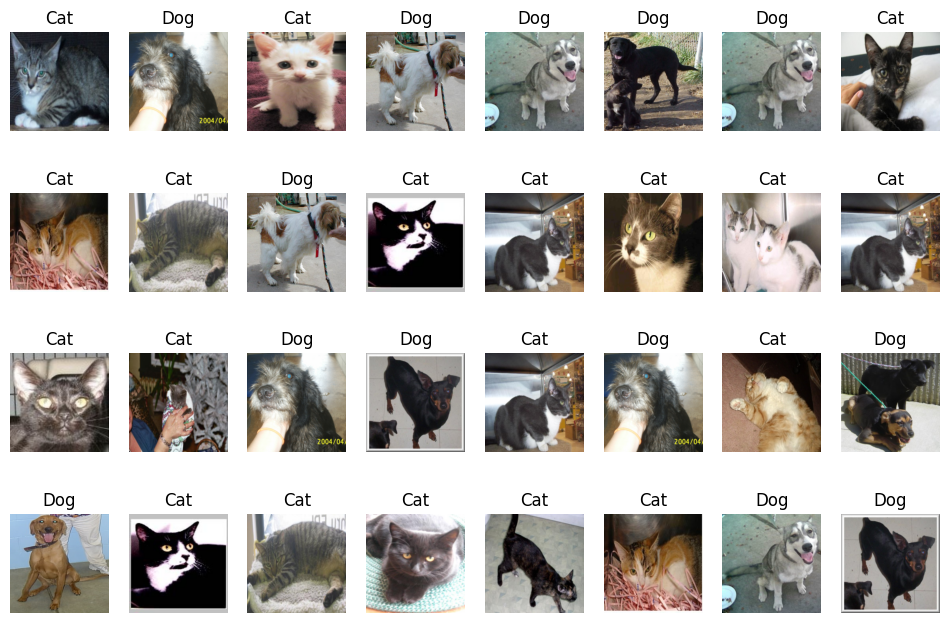

In [12]:
# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [13]:
from torch.utils.data import random_split


ratio = 0.8 # 학습셋(train set)의 비율을 설정합니다.

train_size = int(ratio * len(dataset))
test_size = len(dataset) - train_size
print(f'total: {len(dataset)}\ntrain_size: {train_size}\ntest_size: {test_size}')

# random_split으로 8:2의 비율로 train / test 세트를 분할합니다.
train_data, test_data = random_split(dataset, [train_size, test_size])

total: 24998
train_size: 19998
test_size: 5000


In [14]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers
                         )
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=num_workers
                        )

In [15]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [16]:
# 1개의 이미지의 shape를 확인합니다.
# 224 X 224 RGB 이미지가 잘 로드 되었음을 확인합니다.
images[0].shape

torch.Size([3, 224, 224])

In [17]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [18]:
from torchvision import models # pretrained 모델을 가져오기 위한 import

# VGG16 모델 생성
model = models.vgg16(pretrained=True) # pretrained=True 로 설정, pretrained=False로 설정되었을 경우 가중치는 가져오지 않습니다.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s]  


그 밖의 활용 가능한 pretrained 모델

models.alexnet(pregrained=True) # AlexNet  
models.resnet18(pretrained=True) # ResNet18  
models.inception_v3(pretrained=True) # Inception_V3

In [19]:
# 가중치를 Freeze 하여 학습시 업데이트가 일어나지 않도록 설정합니다.
for param in model.parameters():
    param.requires_grad = False  # 가중치 Freeze

In [20]:
import torch.nn as nn


# Fully-Connected Layer를 Sequential로 생성하여 VGG pretrained 모델의 'Classifier'에 연결합니다.
fc = nn.Sequential(
    nn.Linear(7*7*512, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정합니다.
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2), # Cats vs Dogs 이진 분류이기 때문에 2로 out_features=2로 설정합니다.
)

In [21]:
model.classifier = fc
model.to(device)
# 모델의 구조도 출력
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
import torch.optim as optim
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [23]:
from tqdm import tqdm  # Progress Bar 출력

In [24]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)

        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)

        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()

        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [25]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()

    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()

            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [26]:
# 최대 Epoch을 지정합니다.
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 625/625 [01:35<00:00,  6.53it/s]


[INFO] val_loss has been improved from inf to 0.09852. Saving Model!
epoch 01, loss: 0.10226, acc: 0.95925, val_loss: 0.09852, val_accuracy: 0.96040


100%|██████████| 625/625 [01:36<00:00,  6.50it/s]


[INFO] val_loss has been improved from 0.09852 to 0.08278. Saving Model!
epoch 02, loss: 0.05655, acc: 0.97795, val_loss: 0.08278, val_accuracy: 0.97040


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 03, loss: 0.04001, acc: 0.98565, val_loss: 0.08992, val_accuracy: 0.96980


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 04, loss: 0.02876, acc: 0.99005, val_loss: 0.09001, val_accuracy: 0.96920


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 05, loss: 0.02089, acc: 0.99240, val_loss: 0.12234, val_accuracy: 0.96720


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 06, loss: 0.01712, acc: 0.99480, val_loss: 0.11481, val_accuracy: 0.96100


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 07, loss: 0.01224, acc: 0.99580, val_loss: 0.17094, val_accuracy: 0.96200


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


epoch 08, loss: 0.01281, acc: 0.99565, val_loss: 0.11891, val_accuracy: 0.96980


100%|██████████| 625/625 [01:37<00:00,  6.38it/s]


epoch 09, loss: 0.00859, acc: 0.99670, val_loss: 0.15556, val_accuracy: 0.96740


100%|██████████| 625/625 [01:38<00:00,  6.38it/s]


epoch 10, loss: 0.00872, acc: 0.99695, val_loss: 0.14038, val_accuracy: 0.96760


In [27]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [28]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.08377, evaluation accuracy: 0.96820
